# A Book Recommender Engine Based on LDA Topic Modeling
## Asian Fusion 66
### Group Members
 - Weile Chen: Background Research, Data Collection and Data Visualization 
 - Shaoyu Feng: Text Cleaning and Tokenization, EDA Analysis
 - Mengtong Zhang: LDA Modeling, Parameter Tuning and Model Evaluation
 - Yunjia Zeng: Recommender Building and Poster

## 1 Background and Motivation
A recommender system is a computer program that helps a user discover products and content by predicting the user's propensity of each item and showing them the items that they would like. Recommendation systems plays an important role helping users find the product and content they want. In our project, we want to build a book recommender engine based on Latent Dirichlet Allocation (LDA) model, which is widely used for topic modeling and opinion analysis.

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.

Next, we will conduct our project in 3 steps:
 - Preprocessing the data
     - Read Data
     - EDA Analysis
     - Data Cleaning
 - Modeling
     - Constructing LDA model with *Gensim*.
     - Determining the number of topics with diffrent Measures
     - Illustrating topics with top weights words of each topic
     - Model Evaluation
     - Examples of applying the model
 - The Recommender Engine

## 2 Preprocessing the Data
In this project, we use wikipedia book data as our database. We select 36050 book names (lives in *Book.csv* in the project folder) and request their wikipedia content using *Wikipedia* library in Python. The data lives in _text.csv_ in the project folder, where contains the book names, their corresponding wikipedia content and the length of the content.
### 2.1 Read the Data

In [8]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv('/Users/zmt/Desktop/text.csv',index_col=False).drop(['Unnamed: 0'],axis=1)

In [582]:
data.shape

(36050, 3)

In [583]:
data.head(5)

,name,text,length
0,Freud: His Life and His Mind,Freud: His Life and His Mind is a 1947 biograp...,2859
1,Blackbox (novel),Blackbox is the first novel by British writer ...,596
2,My Real Children,My Real Children is a 2014 alternate history n...,3270
3,The Alleys of Eden,The Alleys of Eden is the first published nove...,1149
4,Day of the Dogs,Day of the Dogs is an original novel written b...,524


In [26]:
print(data.text[0])

Freud: His Life and His Mind is a 1947 biography of Sigmund Freud, the founder of psychoanalysis, by Helen Walker Puner. The book was reprinted in 1959 with a new foreword by the psychoanalyst Erich Fromm. The work was praised by Fromm, but has also received criticism from scholars.


== Summary ==
Puner attempts to explain Freud's life and his accomplishments.


== Publication history ==
Freud: His Life and His Mind was first published in 1947 by Dell Publishing. It was reprinted in 1959 with a new foreword by the psychoanalyst Erich Fromm.


== Reception ==


=== Responses from Freud's family ===
The psychoanalyst Anna Freud was outraged by Puner's work, describing it as "horrible" in a letter to Ernest Jones. Oliver Freud had a less negative view of the book, believing that Puner's errors were the result of citing Carl Jung, Wilhelm Stekel, and Fritz Wittels.


=== Mainstream media ===
The poet Maurice English gave Freud: His Life and His Mind a negative review in The Nation, descri

### 2.2 EDA Analysis
Next, we are going to do some EDA analysis of our data. 
#### Ariticle Length
 - The maximum length of wikipedia articles in our data is 190700.
 - The longest article is *The Britannia's Fist Trilogy*.
 - The minimum length of wikipedia articles in our data is 0.

In [27]:
print('Maximum article text length is: {}'.format(max(data['length'])))
print('Minimum article text length is: {}'.format(min(data['length'])))

Maximum article text length is: 190700
Minimum article text length is: 0


In [50]:
print('The longest article is: ',list(data[data['length']==190700]['name']))
print('The shortest articles are: ',list(data[data['length']==0]['name']))

The longest article is:  ["The Britannia's Fist Trilogy"]
The shortest articles are:  ['File:Rules of play.jpg', 'Making Do', 'File:Stock Photo Strangers from the Sky bookcover.jpg']


#### Article Distribution
We use a bar chart to show the distribution of article length of our data. It is shown that the article length has a right skewed and long tail dirtrubtion, where most of books has a wikipedia article shorter than 25000. For later analysis, we may remove articles with length less than 100 because those articles are too short to provide meaningful insights.

Text(0.5, 1.0, 'Article Length Distribution')

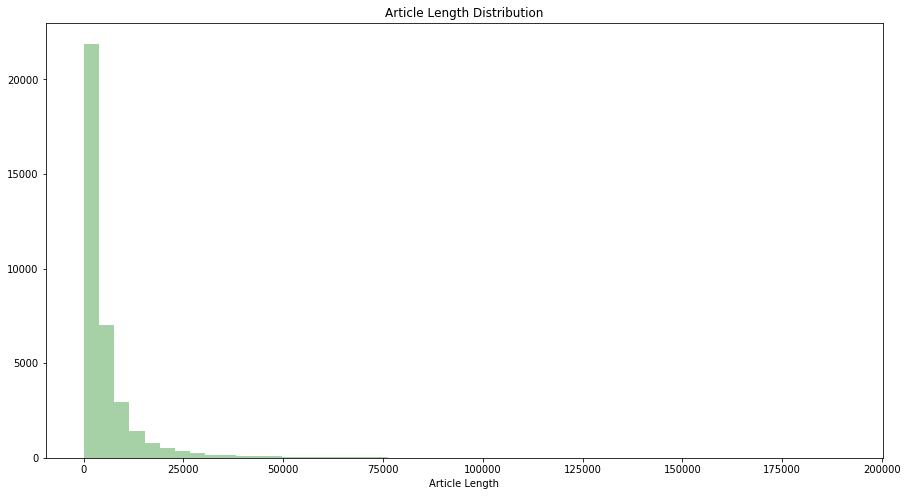

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
fig= plt.figure(figsize=(15,8)) 
sns.distplot(data.length,color='forestgreen',kde=False)
plt.xlabel('Article Length')
plt.title('Article Length Distribution')

In [15]:
data = data[data.length>100]

In [16]:
data.shape

(35991, 3)

### 2.3 Data Cleaning

Data cleaning is a critical step for NLP models. Next, we will do two step data cleaning and reformat the dataset:
 - Book Name Cleaning
 - Article Cleaning
 - Reformat the dataset

#### Book Name Cleaning
Some of the book titles on wikipedia are appended with book itentifier such as *(book)*, *(novel)* etc. We will remove those extra content and only keep the original book name.

In [589]:
print('Before Cleaning:')
for i in data['name'][0:5]:
    print(i)
print('\n')
import re
## book name cleaning
data['cleaned_name'] = [re.sub(r'\(.*?\)', '', i).rstrip() for i in data.name]
print('After Cleaning:')
for i in data['cleaned_name'][0:5]:
    print(i)

Before Cleaning:
Freud: His Life and His Mind
Blackbox (novel)
My Real Children
The Alleys of Eden
Day of the Dogs


After Cleaning:
Freud: His Life and His Mind
Blackbox
My Real Children
The Alleys of Eden
Day of the Dogs


#### Article Cleaning

Next, we are going to clean the text data of articles on wikipedia. We print out the wikipedia content of *Freud: His Life and His Mind* as an example. After tokenize the text using *NLTK*, we mainly did text cleaning in following steps:

 - Removing Fillers 
      - We can see fillers such as *== Summary ==*, *== Reception ==* and *== Publication History ==* etc, which needed to be removed from the text.
 - Removing StopWords
      - We use English stopwords in the library *NLTK* to remove the high frequency words in text.
 - Removing Punctuations
 - Removing Links
 - Removing Numbers

In [590]:
print(data.text[0])

Freud: His Life and His Mind is a 1947 biography of Sigmund Freud, the founder of psychoanalysis, by Helen Walker Puner. The book was reprinted in 1959 with a new foreword by the psychoanalyst Erich Fromm. The work was praised by Fromm, but has also received criticism from scholars.


== Summary ==
Puner attempts to explain Freud's life and his accomplishments.


== Publication history ==
Freud: His Life and His Mind was first published in 1947 by Dell Publishing. It was reprinted in 1959 with a new foreword by the psychoanalyst Erich Fromm.


== Reception ==


=== Responses from Freud's family ===
The psychoanalyst Anna Freud was outraged by Puner's work, describing it as "horrible" in a letter to Ernest Jones. Oliver Freud had a less negative view of the book, believing that Puner's errors were the result of citing Carl Jung, Wilhelm Stekel, and Fritz Wittels.


=== Mainstream media ===
The poet Maurice English gave Freud: His Life and His Mind a negative review in The Nation, descri

In [10]:
import re
import collections
filler = []
for i in range(100):
    filler+= re.findall('==(.*?)==',data.text[i])
c = collections.Counter(filler)
filler = [k.strip().lower() for k in c if c[k]>1]
filler_word = []
for f in filler:
    filler_word+=f.split()
filler_word = list(set(filler_word))

In [17]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
def clean_text(text):
    text = text.lower()
    #add filler into stop words
    stop_words = set(stopwords.words('english') + 
                     ["'s",'one','two','three','four','five','also','would','references','many','may',
                     'book','books','first','later','published','new','story','stories','known','time']
                    + filler_word)
    punctuation = set(list(string.punctuation) + ['…', '...','’','``',"''",'–','“',"n't",'”','isbn'])
    text = re.sub('#', '',text)
    text = re.sub(r'[-\.\n]', '',text)
    text = re.sub(r'&\w+;','',text)
    # Removing links
    text = re.sub(r'https?://\S*', '',text)
    text = text.replace('[^\w\s]','')
    word_tokens = word_tokenize(text)
    filtered_text=[]
    #looping through conditions
    for w in word_tokens:
    #check if w is punctuation or stop_word or numbers
        if w not in punctuation and w not in stop_words and '=' not in w and not w.isnumeric():
            filtered_text.append(w)
    return ' '.join(filtered_text)

In [18]:
data['cleaned_text'] = [clean_text(i) for i in data.text]

After tokenizing and data cleaning, we want to further explore the distribution of article token sizes. And it shows that the token size distribution is very similar to article length. Most articles has a token size less than 2500.

In [596]:
data['token_size'] = [len(item.split()) for item in data.cleaned_text]

Text(0.5, 1.0, 'Article Token Size Distribution')

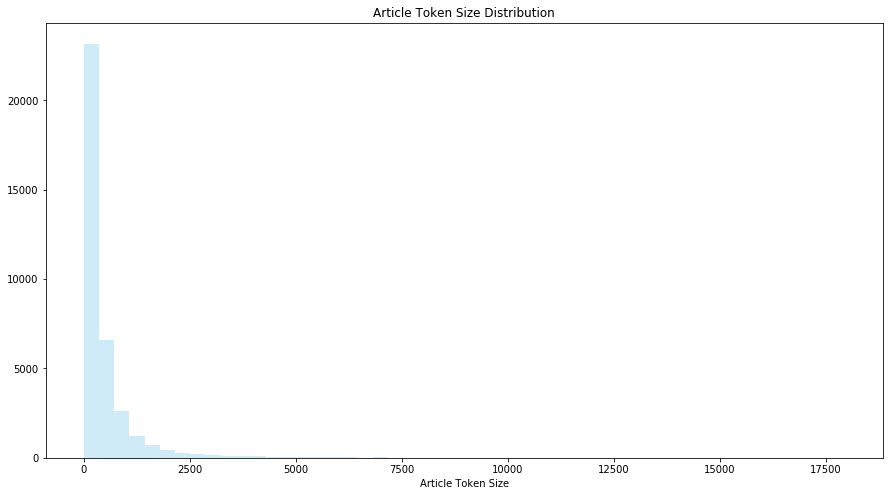

In [598]:
fig= plt.figure(figsize=(15,8)) 
sns.distplot(data.token_size,color='skyblue',kde=False)
plt.xlabel('Article Token Size')
plt.title('Article Token Size Distribution')

Also, we print out the ten words with top frequences and generate a bar chart to show the frequency.

In [367]:
word_list = []
for i in data.cleaned_text:
    word_list += i.split()
text_word_frequency = collections.Counter(word_list)

In [599]:
common10 = text_word_frequency.most_common()[:10]

In [600]:
print(common10)

[('novel', 76898), ('world', 36001), ('life', 35157), ('series', 32314), ('work', 29019), ('years', 27636), ('people', 27584), ('man', 27271), ('american', 26401), ('war', 26292)]


Text(0.5, 1.0, 'Top 10 Words Frequency')

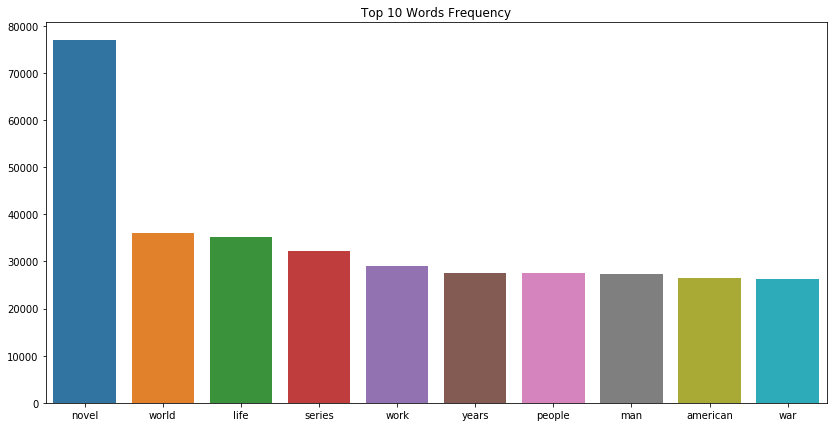

In [604]:
fig= plt.figure(figsize=(14,7))
sns.barplot(x=[i[0] for i in common10], y=[i[1] for i in common10])
plt.title('Top 10 Words Frequency')

## 3 Modeling

In the modeling part, we will use *Latent Dirichlet Allocation* model for articles' topic modeling. Basically we will do it in following steps:
 - Constructing LDA model with *Gensim*.
 - Determining the number of topics with diffrent Measures
 - Illustrating topics with top weights words of each topic
 - Model Evaluation
 - Examples of applying the model

### 3.1 LDA Model Construction

Here we use the library *gensim* for LDA modeling. There are 698015 unique tokens in 35991 articles.

In [19]:
import gensim
from gensim import corpora, models, similarities
articles = [i.split() for i in data.cleaned_text]

In [20]:
%%time
dic = corpora.Dictionary(articles)

CPU times: user 31.5 s, sys: 1.31 s, total: 32.8 s
Wall time: 33.4 s


In [618]:
from itertools import islice
list(islice(dic.iteritems(),20))

[(0, 'according'),
 (1, 'account'),
 (2, 'actual'),
 (3, 'aloof'),
 (4, 'although'),
 (5, 'analytical'),
 (6, 'anna'),
 (7, 'articles'),
 (8, 'astute'),
 (9, 'attempts'),
 (10, 'authors'),
 (11, 'balanced'),
 (12, 'behavior'),
 (13, 'believing'),
 (14, 'biography'),
 (15, 'breger'),
 (16, 'called'),
 (17, 'carl'),
 (18, 'character'),
 (19, 'citing')]

In [373]:
%%time
bow_corpus = [dic.doc2bow(text) for text in articles]

CPU times: user 43.3 s, sys: 1min 49s, total: 2min 32s
Wall time: 10min 10s


In [374]:
print('Number of unique tokens: %d' % len(dic)) 
print('Number of articles: %d' % len(bow_corpus)) 

Number of unique tokens: 698015
Number of articles: 35991


In [375]:
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 2), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 2), (54, 1), (55, 19), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 4), (76, 1), (77, 1), (78, 1), (79, 1), (80, 9), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 5), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 3), (107, 3), (108, 1), (109, 2), (110, 1)

### 3.2 Determining Best Number of Topics
To determining the best number of topics, we tried different number (5,10,15,20,25,30) of topics for LDA modeling. 

#### Topic Coherence: Intrinsic Measure

Topic Coherence is a very important intrinsic measure for topic models. In this part, we will use *c_v* as our  primary topic coherence measure.

*Note: c_v is based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.*

After trying 5,10,15,20,25,30 as our number of topics, it is shown that *number of topics=20* can generate best *c_v* of 0.54. So we will choose 20 as our best number of topics.

In [5]:
import os
import random
nums = [5,10,15,20,25,30]
folder = '/Users/zmt/Desktop/Book_Recommender'
ldamodels = {}
for i in nums:
    random.seed(42)
    if not os.path.exists(folder+'/model/lda_'+str(i)+'.lda'):
        %time ldamodels[i] = models.LdaModel(bow_corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=dic)
        ldamodels[i].save(folder+'/model/lda_'+str(i)+'.lda')
        print('lda_{}.lda created.'.format(i))
    else: 
        print('lda_{}.lda already exists.'.format(i))

In [3]:
from gensim.models.coherencemodel import CoherenceModel
coherence_lda = [0]*len(nums)
for i in range(len(nums)):
    lda_model = models.LdaModel.load(project_folder+'/model/lda_'+str(nums[i])+'.lda')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=articles, dictionary=dic, coherence="c_v")
    coherence_lda[i] = coherence_model_lda.get_coherence()
    print('Number of Topics = ',nums[i],'Coherence Score: ', coherence_lda[i])

[Text(0, 0.5, 'Coherence Score'), Text(0.5, 0, 'Number of Topics')]

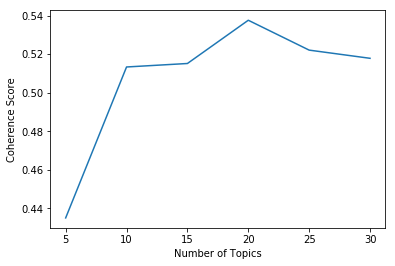

In [378]:
ax = sns.lineplot(x=nums, y=coherence_lda)
ax.set(xlabel = 'Number of Topics',ylabel = 'Coherence Score')

### 3.3 Illustrating topics with top weights words of each topic

We use top 10 words with corresponding weights of them to illustrate each topic.

In [ ]:
num_topics = 20
lda_model= models.LdaModel.load(folder+'/model/lda_'+str(num_topics)+'.lda')

In [390]:
import pprint
topics = lda_model.top_topics(bow_corpus, topn=10)

In [391]:
from pprint import pprint
for i in range(num_topics):
    print('Topic',i)
    pprint(topics[i])
    print('\n')

Topic 0
([(0.01576554, 'novel'),
  (0.005367167, 'life'),
  (0.005123265, 'father'),
  (0.0048534125, 'family'),
  (0.0044982275, 'man'),
  (0.0043142657, 'mother'),
  (0.0040259114, 'love'),
  (0.003997076, 'young'),
  (0.0031627, 'years'),
  (0.003041666, 'woman')],
 -0.9287945373768874)


Topic 1
([(0.005636315, 'school'),
  (0.004684521, 'house'),
  (0.0036707465, "n't"),
  (0.0034238636, 'day'),
  (0.0030271763, 'american'),
  (0.0030062539, 'back'),
  (0.002738913, 'black'),
  (0.0026385006, 'man'),
  (0.0026267592, 'home'),
  (0.0025604018, 'get')],
 -0.9765894341380349)


Topic 2
([(0.0063499664, 'war'),
  (0.005942962, 'states'),
  (0.005394739, 'united'),
  (0.0048523047, 'american'),
  (0.0047672084, 'government'),
  (0.004283751, 'political'),
  (0.004066223, 'people'),
  (0.004019881, 'world'),
  (0.0040071313, 'us'),
  (0.0037993512, 'state')],
 -1.0016657858036568)


Topic 3
([(0.005365561, 'work'),
  (0.004895533, 'human'),
  (0.0041527175, '“'),
  (0.0040725693, '”'),


### 3.4 Model Evaluation

In this part, we will use both intrinsic measure and extrinsic measure for evaluating the model.

#### Intrinsic Measures
As we have mentioned in 3.3, coherence score is the most important intrinsic measure for topic models. Apart from *c_v* we used in 3.3, there are also other intrinsic coherence measures such as *u_mass*.

For our topic model, we get quite good c_v and u_mass:
 - c_v = 0.54
 - u_mass = -6.44

In [630]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=articles, dictionary=dic, coherence="c_v")
coherence_model_lda.get_coherence()

0.5375607052056606

In [21]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=articles, dictionary=dic, coherence="u_mass")
coherence_model_lda.get_coherence()

-6.438169709856728

#### Extrinsic Measures
The UCI measure uses pairwise score function the Pointwise Mutual Information (PMI) for measuring topic coherence. It is an important extrinsic measure for topic model.
 - UCI = -4.05

In [23]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=articles, dictionary=dic, coherence="c_uci")
coherence_model_lda.get_coherence()

-4.0455211738008146

### 3.5 Examples of applying the model

In this part, we use two example books to illustrate the result of topic model.

 - For the novel *My Real Children*, the model cluster it into topic 18, with top words *children*, *little* and *tale*.
 - For the book *God in Search of Man* with religious theme, the model cluster it into topic 15, with top words *muslim*, *islam* and *muhammad*.

In [628]:
print('Book Name: ',data.name[2],'\n')
print(data.text[2])
res = sorted(lda_model[bow_corpus][2],key=lambda x:-x[1])
print('LDA Results:', res,'\n')
print('Topic: ')
for item in topics[res[0][0]][0]:
    print(item)

Book Name:  My Real Children 

My Real Children is a 2014 alternate history novel by Welsh-Canadian writer Jo Walton, published by Tor Books. It was released on May 20, 2014.


== Plot ==
In 2015, Patricia is 89 years old and living in a nursing home, with two mutually-exclusive sets of memories: one of a world where John F. Kennedy was killed by a bomb in 1963, and one of a world where Kennedy chose not to run in 1964 after an escalated Cuban Missile Crisis led to the nuclear obliteration of Miami and Kiev—and, on a more personal level, one in which she went by "Trish", married a man and had four children before she was able to escape an unhappy marriage and become involved in politics, and one in which, as "Pat", she was a successful travel writer raising three children with her lesbian partner. Both feel completely real, but both cannot be... even though both sets of children visit her.


== Patricia's two worlds ==
In the Kennedy assassination timeline, there is accelerated nuclear

In [565]:
print('Book Name: ',data.name[87],'\n')
print(data.text[87])
res = sorted(lda_model[bow_corpus][87],key=lambda x:-x[1])
print('LDA Results:', res,'\n')
print('Topic: ')
for item in topics[res[0][0]][0]:
    print(item)

Book Name:  God in Search of Man 

God in Search of Man: A Philosophy of Judaism is a work on Jewish philosophy by Rabbi Dr. Abraham Joshua Heschel. Heschel saw the work's title as a paradoxical formula, rooted in the rabbinic tradition, summarizing human history as seen in the Bible: God in search of man.In God in Search of Man Heschel articulates a belief in a personal God who sees humankind as partners in creation, forging a world filled with justice and compassion.God in Search of Man: A Philosophy of Judaism is a companion volume to Heschel's earlier work Man Is Not Alone: A Philosophy of Religion where he delineates experiential and philosophical interpretations of Jewish views of humanity and the world, while in God in Search of Man Heschel focuses particularly on Jewish revelation and orthopraxis.


== Contents ==
In God in Search of Man, Heschel discusses the nature of religious thought, how thought becomes faith, and how faith creates responses in the believer. He discusses w

## 4 The Recommender Engine

In this part, we will build a recommender engine based on the LDA model. We will use Pearson Correlation as a similarity measure for diffrent documents. And for each input book, we will generate 10 most similar books based on the similarity as our recommendation. 

We try to generate recommendations for two books:
 - For *Harry Potter and the Deathly Hallows*, the recommender generates top 2 recommendations as *Harry Potter and the Cursed Child* and *Harry Potter and the Half-Blood Prince*.
 - For *God in Search of Man*, the recommender generates top 2 recommendations as *A Dissertation Concerning the End for Which God Created the World* and *A New Christianity for a New World*.
 
Overall, the recommender gave us quite reasonable recommendations according to the input.

In [403]:
index = similarities.MatrixSimilarity(lda_model[bow_corpus])

In [412]:
corpus_lda_model = lda_model[bow_corpus]

In [541]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import stats

In [614]:
data.reset_index(inplace=True)

In [522]:
book_dic = {c:i for i,c in enumerate(data.name)}

In [615]:
def book_recommender(title):
    title_ind = book_dic[title]
    topic_ind = max(lda_model[bow_corpus][title_ind],key=lambda x:x[1])[0]
    print('The prominent topic of',title, 'is','\n')
    print(topics[topic_ind])
    sim = {}
    for i in range(len(data.name)):
        if i!=title_ind:
            #sim[i] = float(cosine_similarity(index[corpus_lda_model[title_ind]].reshape(1,35991),index[corpus_lda_model[i]].reshape(1,35991))[0])
            sim[i] = float(stats.pearsonr(index[corpus_lda_model[title_ind]],index[corpus_lda_model[i]])[0])
    res = sorted(sim.items(),key=lambda x: -x[1])
    recommend = [i[0] for i in res[0:10]]
    recommend_book = [data.name[r] for r in recommend]
    print('\n')
    print('The 10 Recommended Books are:')
    for i in range(10):
        print(recommend_book[i])

In [616]:
book_recommender("Harry Potter and the Deathly Hallows")

The prominent topic of Harry Potter and the Deathly Hallows is 

([(0.009846607, 'novel'), (0.008770875, 'english'), (0.008330953, 'german'), (0.0072951238, 'edition'), (0.0066370084, 'work'), (0.0057772277, 'written'), (0.0056237467, 'author'), (0.00561956, 'isbn'), (0.0049938457, 'war'), (0.004867743, 'translation')], -1.3268352804167174)


The 10 Recommended Books are:
Harry Potter and the Cursed Child
Harry Potter and the Half-Blood Prince
The Mouse and His Child
You're Only Old Once!
Harry Potter and the Order of the Phoenix
Wombat Divine
Fairyland (series)
The Settlers (novel)
Ronia, the Robber's Daughter
Kådisbellan


In [566]:
book_recommender("God in Search of Man")

The prominent topic of God in Search of Man is 

([(0.0077391164, 'russian'), (0.0073286504, 'islamic'), (0.0063367356, 'ali'), (0.006199859, 'muslim'), (0.0058618924, 'islam'), (0.0051998114, 'muhammad'), (0.004599582, 'pakistan'), (0.0044075986, 'arabic'), (0.0040549207, 'ibn'), (0.00362708, 'persian')], -1.994175738295556)


The 10 Recommended Books are:
A Dissertation Concerning the End for Which God Created the World
A New Christianity for a New World
The New Meditation Handbook
The Stoic
The Idea of Perfection
Kavir (book)
The New Heart of Wisdom
Practice in Christianity
The Secret Doctrine
Original Goodness (book)


## 5 References

 - *Building an LDA-Based Book Recommender System*  
 https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/?nsukey=UhUU6y2bnUe9V8D67DnwSbexQYOrQgLrPx2GBgYnqqT%2F7h%2Fi7DzXp%2B2lU3nMziegI6%2B9Gf3oIbmgetIaCWVoAeD1KmWT%2B0%2BmkBorgkFCQTsiGpyrJjLnana78Joj9QfdKANliE%2BSFQGxXnNhpQVO3DVv2euYrL5csLIsBqvUCNv3DguCRecYplylrsiD5Mq5VpSL6Jbe1Y9gEZFG%2BaoejQ%3D%3D
 - *Exploring the Space of Topic Coherence Measures*   
 http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
 - *Blei, D.M., Ng, A.Y., Jordan, M.I. Latent Dirichlet allocation Journal of Machine Learning Research*
 - *Jojo,	S.m.,	Wong,	M.,	Dras,	M.J.:	Topic	modeling	for	native	language	iden- tification.	In:	Proceedings	
of	the	Australasian	Language	Technology	Association	Workshop,	Canberra,	Australia	(2011)	115–124*
 - *Chrupala,G.:	Efficient	induction	of	probabilistic	word	classes	with	LDA.	In:	Proceedings	of	the	Fifth	
International	Joint	Conference	on	Natural	Language	Processing	(IJCNLP	2011).	(2011)	363–372*
 - *Ralf	K., Peter	F.:	 Latent	dirichlet	allocation	for	tag	recommendation (2009)*